In [1]:
import os
import pickle
import numpy as np
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.utils import Sequence
from keras.models import Sequential
from keras.models import load_model
from keras.applications import ResNet50
from keras.layers import Dense, Flatten, Dropout
from sklearn.metrics import confusion_matrix, classification_report

c:\Users\Abdul Manaf\AppData\Local\Programs\Python\Python39\lib\site-packages\scipy\__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  2


In [3]:
batch_size = 64
dataset_code = 'AIDER'
model_name = 'ResNet50'
data_saved_dir = r'E:\Disaster\AIDER\\pickle\\'
model_saved_dir = r'E:\Disaster\\runs\\'
train_data_path = f'{data_saved_dir}\\train_data.pkl'
val_data_path = f'{data_saved_dir}\\val_data.pkl'
test_data_path = f'{data_saved_dir}\\test_data.pkl'

In [4]:
def load_pickle(file_path):
    with open(file_path, 'rb') as f:
        data = pickle.load(f)
    return data

train_images, train_labels = load_pickle(train_data_path)
val_images, val_labels = load_pickle(val_data_path)
test_images, test_labels = load_pickle(test_data_path)

print(f'Training images: {train_images.shape}')
print(f'Validation images: {val_images.shape}')
print(f'Testing images: {test_images.shape}')

Training images: (4501, 256, 256, 3)
Validation images: (965, 256, 256, 3)
Testing images: (967, 256, 256, 3)


In [5]:
train_images[0]

array([[[0.58431375, 0.5764706 , 0.627451  ],
        [0.59607846, 0.5803922 , 0.6392157 ],
        [0.6117647 , 0.5764706 , 0.6431373 ],
        ...,
        [0.22352941, 0.11372549, 0.10196079],
        [0.28235295, 0.21568628, 0.1764706 ],
        [0.3529412 , 0.30588236, 0.2509804 ]],

       [[0.6       , 0.58431375, 0.6392157 ],
        [0.59607846, 0.57254905, 0.627451  ],
        [0.5921569 , 0.56078434, 0.61960787],
        ...,
        [0.30980393, 0.2       , 0.1882353 ],
        [0.34117648, 0.27450982, 0.23529412],
        [0.42352942, 0.3764706 , 0.3137255 ]],

       [[0.5882353 , 0.5568628 , 0.60784316],
        [0.58431375, 0.5529412 , 0.59607846],
        [0.5686275 , 0.5254902 , 0.5803922 ],
        ...,
        [0.3137255 , 0.20392157, 0.19215687],
        [0.27058825, 0.20392157, 0.17254902],
        [0.39607844, 0.3529412 , 0.28235295]],

       ...,

       [[0.42352942, 0.41568628, 0.46666667],
        [0.39215687, 0.38431373, 0.43529412],
        [0.49019608, 0

In [6]:
train_labels[0]

'traffic_incident'

In [7]:
import numpy as np
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()

# Function to convert labels into one-hot encoding
def one_hot_encode_labels(labels):
        
    # Fit the label encoder to the labels and transform to integers
    integer_labels = label_encoder.fit_transform(labels)
    
    # Convert the integer labels into one-hot encoding
    one_hot_labels = np.zeros((len(labels), len(label_encoder.classes_)))
    one_hot_labels[np.arange(len(labels)), integer_labels] = 1
    
    return one_hot_labels, label_encoder.classes_

# Load your dataset (assuming train_labels, val_labels, test_labels are already loaded)
train_one_hot, classes = one_hot_encode_labels(train_labels)
val_one_hot, _ = one_hot_encode_labels(val_labels)
test_one_hot, _ = one_hot_encode_labels(test_labels)

# Verify the output
print(f"One-hot encoded train labels shape: {train_one_hot.shape}")
print(f"One-hot encoded validation labels shape: {val_one_hot.shape}")
print(f"One-hot encoded test labels shape: {test_one_hot.shape}")

One-hot encoded train labels shape: (4501, 5)
One-hot encoded validation labels shape: (965, 5)
One-hot encoded test labels shape: (967, 5)


In [8]:
train_one_hot[0]

array([0., 0., 0., 0., 1.])

In [9]:
# Assuming `label_encoder` was used to encode the labels
original_label = label_encoder.inverse_transform([np.argmax(train_one_hot[0])])
print(f"The original label for the one-hot encoding {train_one_hot[0]} is: {original_label[0]}")

The original label for the one-hot encoding [0. 0. 0. 0. 1.] is: traffic_incident


In [10]:
import numpy as np
from tensorflow.keras.utils import Sequence

class CustomDataGenerator(Sequence):
    def __init__(self, images, labels, batch_size):
        """
        Initialize the data generator.

        :param images: Array of image data
        :param labels: One-hot encoded labels
        :param batch_size: The number of samples per batch
        """
        self.images = images
        self.labels = labels
        self.batch_size = batch_size
        self.indexes = np.arange(len(self.images))

    def __len__(self):
        """
        Denotes the number of batches per epoch
        """
        return int(np.ceil(len(self.images) / self.batch_size))

    def __getitem__(self, index):
        """
        Generate one batch of data.

        :param index: The batch index
        :return: A batch of images and one-hot encoded labels
        """
        start = index * self.batch_size
        end = (index + 1) * self.batch_size

        # Get the images and labels for the batch
        batch_images = self.images[start:end]
        batch_labels = self.labels[start:end]

        return batch_images, batch_labels

# Assuming you have the one-hot encoded labels: train_one_hot, val_one_hot, test_one_hot
train_data_generator = CustomDataGenerator(train_images, train_one_hot, batch_size=32)
val_data_generator = CustomDataGenerator(val_images, val_one_hot, batch_size=32)
test_data_generator = CustomDataGenerator(test_images, test_one_hot, batch_size=32)

In [11]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  2


In [12]:
ResNet50_model = ResNet50(include_top=False, weights='imagenet', input_shape=(256, 256, 3))

model = Sequential()
model.add(ResNet50_model)

for layer in model.layers:
    layer.trainable = False

model.add(Flatten())
model.add(Dense(units=2048, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(units=5, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 8, 8, 2048)        23587712  
                                                                 
 flatten (Flatten)           (None, 131072)            0         
                                                                 
 dense (Dense)               (None, 2048)              268437504 
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense_1 (Dense)             (None, 5)                 10245     
                                                                 
Total params: 292,035,461
Trainable params: 268,447,749
Non-trainable params: 23,587,712
_________________________________________________________________


In [13]:
from keras.callbacks import ModelCheckpoint, EarlyStopping

model_dir = f'{model_saved_dir}\{dataset_code}_{model_name}'
if not os.path.exists(model_dir):
    os.makedirs(model_dir)
else:
    print(f'{model_dir} already exists')

filename = 'weights-improvement-{epoch:02d}-{val_accuracy:.2f}'
filepath = f'{model_dir}\{dataset_code}_{model_name}-{filename}.keras'  # Change extension to .keras

checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

early_stop = EarlyStopping(monitor='val_loss', patience=3, verbose=1)

callbacks_list = [checkpoint, early_stop]

In [14]:
history = model.fit(train_data_generator, epochs=50, validation_data=val_data_generator, callbacks = callbacks_list)

Epoch 1/50
141/141 [==============================] - ETA: 0s - loss: 11.9857 - accuracy: 0.5836
Epoch 1: val_accuracy improved from -inf to 0.69845, saving model to E:\Disaster\\runs\\\AIDER_ResNet50\AIDER_ResNet50-weights-improvement-01-0.70.keras
141/141 [==============================] - 49s 308ms/step - loss: 11.9857 - accuracy: 0.5836 - val_loss: 0.9433 - val_accuracy: 0.6984
Epoch 2/50
141/141 [==============================] - ETA: 0s - loss: 1.1014 - accuracy: 0.6810
Epoch 2: val_accuracy improved from 0.69845 to 0.70466, saving model to E:\Disaster\\runs\\\AIDER_ResNet50\AIDER_ResNet50-weights-improvement-02-0.70.keras
141/141 [==============================] - 42s 297ms/step - loss: 1.1014 - accuracy: 0.6810 - val_loss: 0.9826 - val_accuracy: 0.7047
Epoch 3/50
141/141 [==============================] - ETA: 0s - loss: 1.0644 - accuracy: 0.6816
Epoch 3: val_accuracy did not improve from 0.70466
141/141 [==============================] - 19s 131ms/step - loss: 1.0644 - accurac

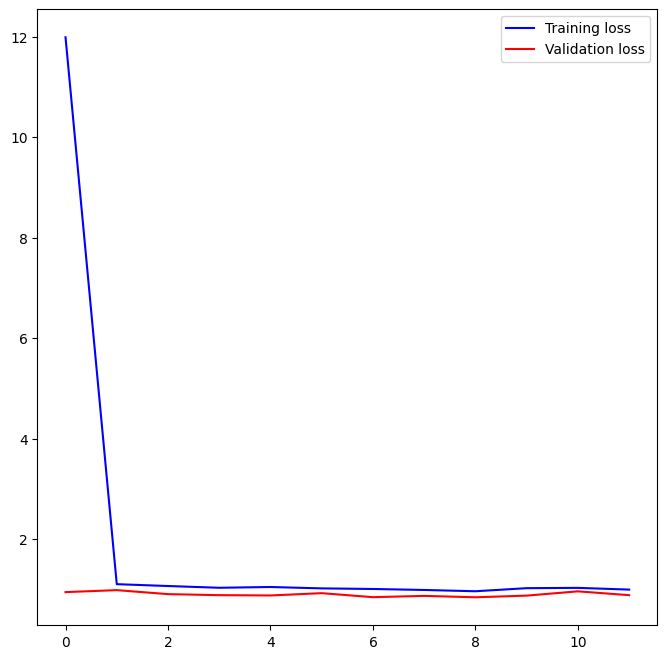

<Figure size 640x480 with 0 Axes>

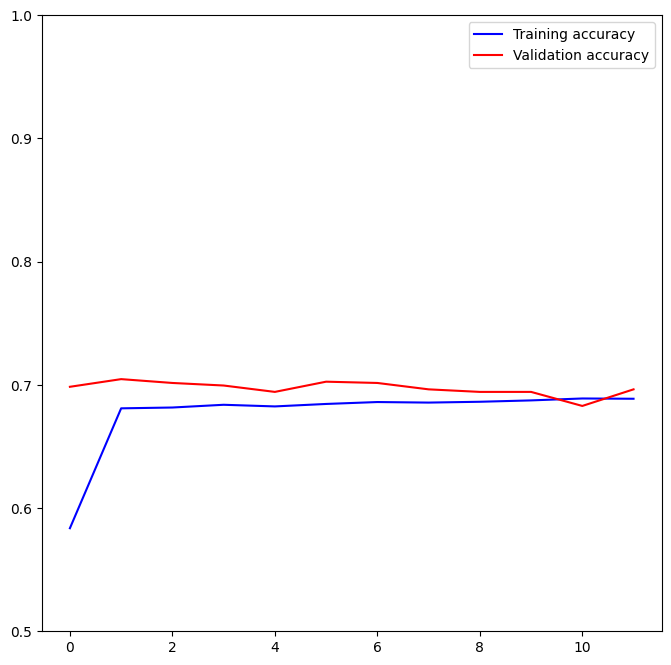

In [15]:
plt.figure(figsize=(8,8))
plt.plot(history.history['loss'], color='b', label="Training loss")
plt.plot(history.history['val_loss'], color='r', label="Validation loss")
plt.legend()
plt.show()

plt.figure()

plt.figure(figsize=(8,8))
plt.plot(history.history['accuracy'], color='b', label="Training accuracy")
plt.plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
plt.legend()
plt.ylim(0.5, 1)
plt.show()

In [16]:
label_encoder.classes_

array(['collapsed_building', 'fire', 'flooded_areas', 'normal',
       'traffic_incident'], dtype='<U18')

31/31 [==============================] - 4s 93ms/step


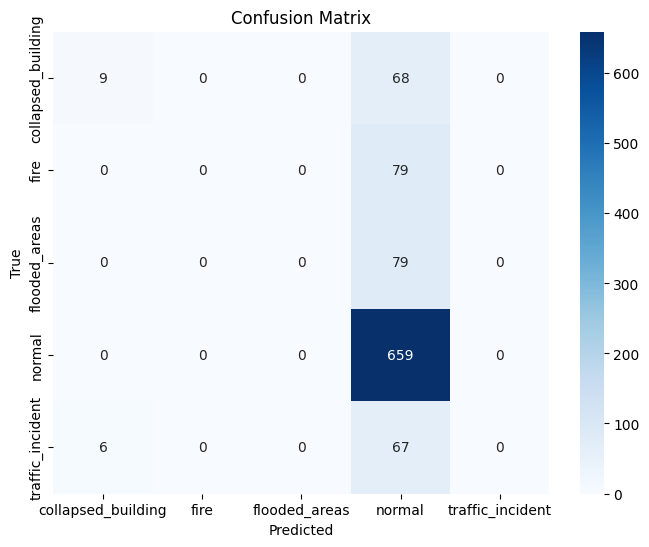

Classification Report:
                    precision    recall  f1-score   support

collapsed_building       0.60      0.12      0.20        77
              fire       0.00      0.00      0.00        79
     flooded_areas       0.00      0.00      0.00        79
            normal       0.69      1.00      0.82       659
  traffic_incident       0.00      0.00      0.00        73

          accuracy                           0.69       967
         macro avg       0.26      0.22      0.20       967
      weighted avg       0.52      0.69      0.57       967



c:\Users\Abdul Manaf\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Abdul Manaf\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Abdul Manaf\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _wa

In [17]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Generate predictions using the model
predictions = model.predict(test_data_generator)

# Convert predictions to integer labels (class with highest probability)
predicted_labels = np.argmax(predictions, axis=1)

# If test_labels are in string format (class names), convert them to integer labels
true_labels = label_encoder.transform(test_labels)  # Use label_encoder to convert to integer labels

# Get class names from the label encoder (ensure label_encoder is already defined)
class_names = label_encoder.classes_

# Compute confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Print the classification report
print("Classification Report:")
print(classification_report(true_labels, predicted_labels, target_names=class_names))